<a href="https://colab.research.google.com/github/hkaido0718/SupportRestriction/blob/main/Interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interference
Let $Y_i$ be a binary outcome indicating whether individual $i$ smoked after the intervention. Let $z=(z_1,z_2)$ be a vector indicating the treatment status of individuals 1 and 2, and we let $Y_i(z)$ denote individual $i$'s potential outcome. $Y(z)=(Y_1(a),Y_2(z))$, where $Y_1(z)$ is the subject's outcome, whereas $Y_2(z)$ is the spouse's outcome. In the paper, we assume the exposure level

\begin{align}
D_i(z)=\begin{cases}
3& \text{ if }z_i=SIA\\
2& \text{ if }z_i=SIP\\
1& \text{ if }z_i=C, z_{-i}\in \{SIA,SIP\}\\
0& \text{ if }z_i=C,z_{-i}=C,
\end{cases}
\end{align}

determines the outcome. This allows us to define a potential outcome $\tilde Y_i(d)$ such that $\tilde Y_i(d)=Y_i(z)$ for any $z$ with $D_i(z)=d$. Consider testing the no-spillover assumption:
\begin{align}
D_i(z)=1,~ D_i(z')=0~\Rightarrow~Y_i(z)= Y_i(z').
\end{align}
 The no spillover effect restriction can also be expressed more succinctly as $\tilde Y_i(1)= \tilde Y_i(0), ~a.s.$ The following code builds a potential response graph based on $\tilde Y(\cdot)$.


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create vertex set
V = [(y, d) for d in range(4) for y in (0, 1)]

# Initialize graph
G = nx.Graph()
G.add_nodes_from(V)

# Add edges following the specified rules
for i, node1 in enumerate(V):
    for node2 in V[i+1:]:
        y1, d1 = node1
        y2, d2 = node2

        # Rule 1: no edges within same group
        if d1 == d2:
            continue

        # Rule 2: no edges between (y,1) and (y',0) if y != y'
        if ((d1 == 1 and d2 == 0) or (d1 == 0 and d2 == 1)) and y1 != y2:
            continue

        # Otherwise add edge
        G.add_edge(node1, node2)

Let's draw the potential response graph.

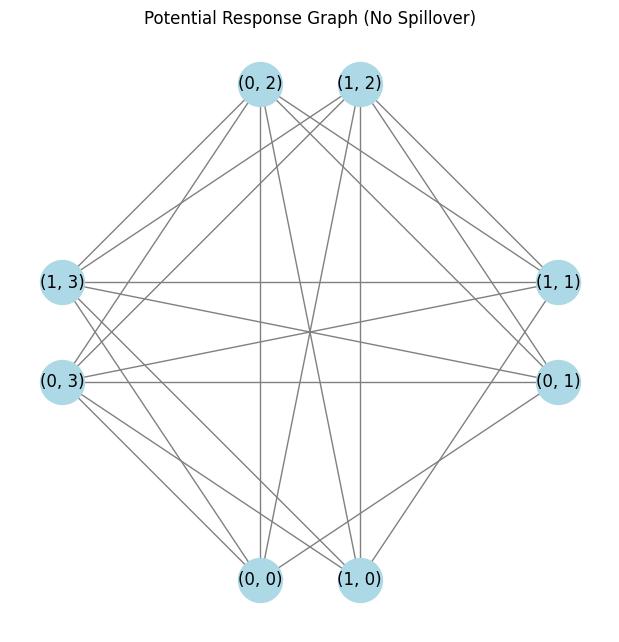

In [11]:
# Define layout: place nodes by group in compass positions
groups = {
    "bottom": [(0, 0), (1, 0)],
    "right": [(0, 1), (1, 1)],
    "top": [(0, 2), (1, 2)],
    "left": [(0, 3), (1, 3)]
}

# Custom positions for plotting
pos = {}

# Spacing between nodes in each group
spacing = 0.2
for i, node in enumerate(groups["bottom"]):
    pos[node] = (-spacing + i * spacing * 2, -1)
for i, node in enumerate(groups["top"]):
    pos[node] = (-spacing + i * spacing * 2, 1)
for i, node in enumerate(groups["right"]):
    pos[node] = (1, -spacing + i * spacing * 2)
for i, node in enumerate(groups["left"]):
    pos[node] = (-1, -spacing + i * spacing * 2)

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, edge_color='gray')
plt.title("Potential Response Graph (No Spillover)")
plt.axis('off')
plt.show()

Now let's find all MISs.


In [10]:
G_complement = nx.complement(G)
all_mis = list(nx.find_cliques(G_complement))

# Filter out MISs that come from a single group (same d)
def group_d(mis):
    return {d for (y, d) in mis}

filtered_mis = [mis for mis in all_mis if len(group_d(mis)) > 1]

# Print results
print("Maximal Independent Sets (excluding single-group ones):")
for i, mis in enumerate(filtered_mis, 1):
    print(f"{i}: {sorted(mis)}")

Maximal Independent Sets (excluding single-group ones):
1: [(0, 1), (1, 0)]
2: [(0, 0), (1, 1)]


The algorithm found two MISs:
- MIS1: $\{v_{(0,1)},v_{(1,0)}\}$
- MIS2: $\{v_{(0,0)},v_{(1,1)}\}$
implying
\begin{align}
P(Y_i=1\,|\,D_i=0,W_i)+P(Y_i=0\,|\,D_i=1,W_i)&\leqslant 1\\
P(Y_i=0\,|\,D_i=0,W_i)+P(Y_i=1\,|\,D_i=1,W_i)&\leqslant 1.
\end{align}
Now, let's check the regularity of the model.

In [12]:
import networkx as nx
from itertools import combinations

def is_induced_cycle(G):
    """Check if G is an induced cycle of length ≥ 5"""
    n = G.number_of_nodes()
    m = G.number_of_edges()
    # A simple cycle must have n nodes and n edges, each degree = 2
    if n < 4 or not nx.is_connected(G):
        return False
    if m != n:
        return False
    if not all(deg == 2 for node, deg in G.degree()):
        return False
    return True

def is_perfect_graph(G):
    def has_odd_hole(G):
        for k in range(5, len(G.nodes) + 1, 2):  # odd lengths only
            for nodes in combinations(G.nodes, k):
                subG = G.subgraph(nodes)
                if is_induced_cycle(subG):
                    print(f"Found odd hole: {nodes}")
                    return True
        return False

    def has_odd_antihole(G):
        Gc = nx.complement(G)
        return has_odd_hole(Gc)

    if has_odd_hole(G):
        print("G contains an odd hole ⇒ not perfect.")
        return False
    if has_odd_antihole(G):
        print("G contains an odd antihole ⇒ not perfect.")
        return False

    print("No odd holes or antiholes ⇒ G is perfect.")
    return True
is_perfect_graph(G)

No odd holes or antiholes ⇒ G is perfect.


True

The code shows $G$ is perfect.

In [14]:
def violates_y_condition(clique):
    """Check if clique violates the condition:
       if (d=1, d'=0) then y must equal y'."""
    for (y1, d1), (y2, d2) in combinations(clique, 2):
        if ((d1 == 1 and d2 == 0) or (d1 == 0 and d2 == 1)) and y1 != y2:
            return True  # violates the condition
    return False  # passes the condition

def enumerate_cliques_and_check(G):
    cliques = list(nx.find_cliques(G))
    print(f"Total maximal cliques: {len(cliques)}\n")
    for i, clique in enumerate(cliques, 1):
        status = "✅ satisfies no spillover" if not violates_y_condition(clique) else "❌ violates no spillover"
        print(f"{i}: {sorted(clique)} — {status}")

enumerate_cliques_and_check(G)

Total maximal cliques: 8

1: [(0, 0), (0, 1), (0, 2), (0, 3)] — ✅ satisfies no spillover
2: [(0, 2), (0, 3), (1, 0), (1, 1)] — ✅ satisfies no spillover
3: [(0, 0), (0, 1), (0, 2), (1, 3)] — ✅ satisfies no spillover
4: [(0, 2), (1, 0), (1, 1), (1, 3)] — ✅ satisfies no spillover
5: [(0, 0), (0, 1), (0, 3), (1, 2)] — ✅ satisfies no spillover
6: [(0, 3), (1, 0), (1, 1), (1, 2)] — ✅ satisfies no spillover
7: [(0, 0), (0, 1), (1, 2), (1, 3)] — ✅ satisfies no spillover
8: [(1, 0), (1, 1), (1, 2), (1, 3)] — ✅ satisfies no spillover


Every maximal clique is a support point (i.e. satisfies the no spillover assumption). So, the model is regular. Hence, the aforementioned inequalities are sharp.

Now, we do the same exercise for a weaker model that only imposes non-positive spillover effect:
\begin{align}
D_i(z)=1,~ D_i(z')=0~\Rightarrow~Y_i(z)\leqslant Y_i(z').
\end{align}

In [18]:
# Initialize graph
G_npos = nx.Graph()
G_npos.add_nodes_from(V)

# Add edges following the specified rules
for i, node1 in enumerate(V):
    for node2 in V[i+1:]:
        y1, d1 = node1
        y2, d2 = node2

        # Rule 1: no edges within same group
        if d1 == d2:
            continue

        # Rule 2: no edges between (y,1) and (y',0) if y > y'
        if d1 == 1 and d2 == 0 and y1 > y2:
            continue

        # Rule 3: no edges between (y,0) and (y',1) if y < y'
        if d1 == 0 and d2 == 1 and y1 < y2:
            continue

        # Otherwise add edge
        G_npos.add_edge(node1, node2)

# Get MIS
G_npos_complement = nx.complement(G_npos)
all_mis_npos = list(nx.find_cliques(G_npos_complement))

# Filter out MISs that come from a single group (same d)
def group_d(mis_npos):
    return {d for (y, d) in mis_npos}

filtered_mis_npos = [mis_npos for mis_npos in all_mis_npos if len(group_d(mis_npos)) > 1]

# Print results
print("Maximal Independent Sets (excluding single-group ones):")
for i, mis in enumerate(filtered_mis_npos, 1):
    print(f"{i}: {sorted(mis)}")
is_perfect_graph(G_npos)

def violates_y_condition(clique):
    """Check if clique violates the condition:
       if (d=1, d'=0) then y must equal y'."""
    for (y1, d1), (y2, d2) in combinations(clique, 2):
        if d1 == 1 and d2 == 0 and y1 > y2:
            return True  # violates the condition
        if d1 == 0 and d2 == 1 and y1 < y2:
            return True  # violates the condition
    return False  # passes the condition

def enumerate_cliques_and_check(G):
    cliques = list(nx.find_cliques(G))
    print(f"Total maximal cliques: {len(cliques)}\n")
    for i, clique in enumerate(cliques, 1):
        status = "✅ satisfies non-positive spillover" if not violates_y_condition(clique) else "❌ violates non-positive spillover"
        print(f"{i}: {sorted(clique)} — {status}")
enumerate_cliques_and_check(G_npos)

Maximal Independent Sets (excluding single-group ones):
1: [(0, 0), (1, 1)]
No odd holes or antiholes ⇒ G is perfect.
Total maximal cliques: 12

1: [(0, 1), (0, 2), (0, 3), (1, 0)] — ✅ satisfies non-positive spillover
2: [(0, 1), (0, 2), (1, 0), (1, 3)] — ✅ satisfies non-positive spillover
3: [(0, 0), (0, 1), (0, 2), (0, 3)] — ✅ satisfies non-positive spillover
4: [(0, 0), (0, 1), (0, 2), (1, 3)] — ✅ satisfies non-positive spillover
5: [(0, 1), (0, 3), (1, 0), (1, 2)] — ✅ satisfies non-positive spillover
6: [(0, 1), (1, 0), (1, 2), (1, 3)] — ✅ satisfies non-positive spillover
7: [(0, 0), (0, 1), (0, 3), (1, 2)] — ✅ satisfies non-positive spillover
8: [(0, 0), (0, 1), (1, 2), (1, 3)] — ✅ satisfies non-positive spillover
9: [(0, 2), (0, 3), (1, 0), (1, 1)] — ✅ satisfies non-positive spillover
10: [(0, 2), (1, 0), (1, 1), (1, 3)] — ✅ satisfies non-positive spillover
11: [(0, 3), (1, 0), (1, 1), (1, 2)] — ✅ satisfies non-positive spillover
12: [(1, 0), (1, 1), (1, 2), (1, 3)] — ✅ satisfies

The algorithm found a single MIS:
- MIS: $\{v_{(0,0)},v_{(1,1)}\}$

implying
\begin{align}
P(Y_i=0\,|\,D_i=0,W_i)+P(Y_i=1\,|\,D_i=1,W_i)&\leqslant 1,
\end{align}
which issharp due to the regularity of the support restriction.